# Final Project#

For the final project, I have chosen to create a machine learning model based on the 30-ICU readmissions based on the MIMIC-III database.

The MIMIC-III database is as cited below:

MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available from: 
http://www.nature.com/articles/sdata201635


In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Overview and Background##

The project that I have chosen to investigate is in creating a machine learning model based on predicting on whether a particular patient will be readmitted within 30-days. While the basis behind this problem may not be particularly evident, there is actually a variety of reasons why predicting whether a patient will be readmitted is particularly useful.

The first of these is in terms of the financial costs to the hospital institution. The idea behind evaluating 30-day readmissions is that if a patient is sick enough to come back within 30-days of last entering the hospital, it is highly likely that they were not in a stable enough condition to be discahrged in the first place. By predicting the patients that are at high risk for readmission, it is possible to reduce the amount of unnnecessary financial burden on the hospital since readmissions are particularly draining on hospital resources.

The second problem that this would help solve would be in reducing the amount of space that are required to house these readmitted patients. When a patient is readmitted within 30 days from their discharge, they not only drain financial resources from the hospital, but can also take up necessary bed space and hospital space that could be potentially needed to treat other patients. 

In this sense, if physcians had the means to predict whether a patient were at high risk to be readmitted, they would be able to take extra measures to make sure the patients are kept in the hospital and not discharged until they are unlikely to be readmitted within a short period of time.

## Data 

### Importing Data

For the purposes of this project, I have drawn a lot of insight from the Capstone project done here: https://github.com/YaronBlinder/MIMIC-III_readmission/blob/master/Report.pdf 

Based on some of the previous work done, I determined the tables I wanted to download from the Mimic III database. The **admissions** table gives me relevant information such as Subject ID, Admission ID, Admit Time, Discharge Time, Death Time (if died during stay), Marital Status and Insurance provider. From the **patients** table, I can obtain information such Age and Gender. From the **lab events** I was able to determine the numerical values for lab tests based on their test ID and from **D_LABITEMS** I was able to find the lab test IDs for the actual tests that I am interested in (namely Calcium (Total), Albumin, Urea Nitrogen and Magnesium)

Since the **lab events** table was most likely too big to be loaded into memory of the Jupyter Notebook, I parsed out only the columns that I wanted (SUBJECT_ID, HADM_ID, ITEM_ID and VALUENUM) and then took the first 2 million rows of the data set. This was done on command line using the following commands:

*cut -d , -f 2,4-6 LABEVENTS.csv > test.csv*  
*sudo head -n 2000000 test.csv > cleaned_data.csv*

In [2]:
admissions = pd.read_csv('ADMISSIONS.csv')
labevents = pd.read_csv('cleaned_data.csv')
D_lab = pd.read_csv('D_LABITEMS.csv')
patients = pd.read_csv('PATIENTS.csv')

### Cleaning Up the Data

In the labevents csv file, there were many cases where there was no information in the HADM_ID section. These correspond with outpatients and will not be something that I will be considering. As such, the first step that I took was in removing any NaN values that existed in the HADM_ID column of the labevents dataframe.

Next, since I want to be use age as a statistic, I will calculate the patient's age based on their DOB (unless they have a DOB, in which case I will calculate their age by subtracting the DOB from the DOD). To find the patients that are still alive, since I was uncertain about how the timestamps were recorded, I decided to make the current time one year after the latest date of death and use that as the current time stamp.

To make the dataset easier to visualize, upon the calculating the age, I also removed information that was not relevant to the machine learning process.

In [3]:
labevents = labevents.dropna()
# removes all rows that have are NaN in the dataframe - in this case, only HADM_ID has NaNs

patients['DOB'] = pd.to_datetime(patients['DOB'])
patients['DOD'] = pd.to_datetime(patients['DOD'])
# converts DOD and DOB to data time objects in the pd dataframe

print((patients['DOD']).max())
currentTime = pd.Timestamp(2212, 6, 10, 10, 10, 10)
# find the current time by adding one year onto the most recent date of death

patients['Age'] = ((patients['DOD'] - patients['DOB']).dt.days)/365
# for the rows that do not have NaN in the DOD column, subtract the DOB from DOD to get the age at their time of death

patients['CurrentTime'] = currentTime
patients['CurrentTime'] = pd.to_datetime(patients['CurrentTime'])

patients['Temp'] = (patients['CurrentTime'] - patients['DOB']).dt.days/365
# creates a temporary column that has the ages of the patients - including all the patients that have died

patients.loc[patients['Age'].isna(), 'Age'] = patients['Temp']
# for all the ages that are nan - i.e. the patients that do not have a DOD value -, replace it with the age calculated

patients = patients[['SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'Age']]

patients.head()

2211-06-10 00:00:00


,SUBJECT_ID,GENDER,DOB,DOD,Age
0,249,F,2075-03-13,NaT,137.334247
1,250,F,2164-12-27,2188-11-22,23.920548
2,251,M,2090-03-15,NaT,122.317808
3,252,M,2078-03-06,NaT,134.350685
4,253,F,2089-11-26,NaT,122.616438


I then further cleaned up, and made the **labevents** table smaller by only keeping the lab tests that I thought were relevant to the machine learning model. I got the *ITEMID* of the tests corresponding to the four categories I listed below.

Calcium (Total) - 50893   
Albumin - 50862   
Urea Nitrogen - 51006   
Magnesium - 50960


In [4]:
labevents = labevents.loc[(labevents['ITEMID'] == 50893) | (labevents['ITEMID'] == 50862) | 
                          (labevents['ITEMID']==51006) | (labevents['ITEMID'] == 50960)]
# locates and only keeps the rows that correspond to the 4 subject codes for calcium, albumin, urea and magnesium

labevents.head()

,SUBJECT_ID,HADM_ID,ITEMID,VALUENUM
162,3,145834.0,50893,8.2
168,3,145834.0,50960,2.4
178,3,145834.0,50893,7.6
182,3,145834.0,50960,2.1
187,3,145834.0,51006,36


On top of all the other preprocessing that I am doing, one thing that will eventually be important for the machine learning portion using sklearn will be that scikit-learn only understands numeric inputs. To this end, all the important columns that I will be using in the machine learning model must be converted into numeric models. Sklearn provides a good way to do this.

In [5]:
from sklearn import preprocessing

# create the Labelencoder object
le = preprocessing.LabelEncoder()

#convert the categorical columns into numeric

admissions['INSURANCE'] = le.fit_transform(admissions['INSURANCE'])
# where 0 corresponds to Government, 1 to Medicaid, 2 to Medicare, 3 to Private and 4 to Self Pay

admissions['MARITAL_STATUS'].fillna('', inplace=True)
# fill the nan values with the empty string to allow for the transformation of the fit
# 0 corresponds to the empty string

admissions['MARITAL_STATUS'] = le.fit_transform(admissions['MARITAL_STATUS'])

patients['GENDER'] = le.fit_transform(patients['GENDER'])
# where 0 corresponds to F and 1 corresponds with M

I also want to change the ADMITTIME and DISCHTIME values into datetime values so I can utilize them later

In [6]:
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])

Following this, I combined the **labevents** table with the the **D_LABITEMS** table so that I would be able to better see on the table what each of the lab tests actually was.

In [7]:
mergedLab = pd.merge(labevents, D_lab[['ITEMID', 'LABEL']], on='ITEMID')
# merges the labevents and D_lab dataframe on the column 'ITEMID', while only selecting the columns of ITEMID and LABEL from
# the D_lab dataframe

Upon inspection, I realized that the VALUENUM column actually contained string values. I will want to use the values later
as a means for doing some data visualizations so I will need to change the value column to either integer or float values

In [8]:
mergedLab.VALUENUM = mergedLab.VALUENUM.astype(float).fillna(0.0)
mergedLab.head()

,SUBJECT_ID,HADM_ID,ITEMID,VALUENUM,LABEL
0,3,145834.0,50893,8.2,"Calcium, Total"
1,3,145834.0,50893,7.6,"Calcium, Total"
2,3,145834.0,50893,7.1,"Calcium, Total"
3,3,145834.0,50893,7.5,"Calcium, Total"
4,3,145834.0,50893,7.4,"Calcium, Total"


I then also cleaned up the **admissions** table by only picking out the important information such as subject ID, admission ID, admit time, discharge time, death time, marital status and insurance provider.

I also merged the admissions with the patient table based on the *SUBJECT_ID* column.

In [9]:
mergedAdmission = pd.merge(patients, admissions[['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME',
                                                 'DISCHTIME', 'DEATHTIME', 'INSURANCE', 'MARITAL_STATUS']], on='SUBJECT_ID')

# merges the patients the admissions table together based on the column of 'SUBJECT_ID'
mergedAdmission.head(50)

,SUBJECT_ID,GENDER,DOB,DOD,Age,ROW_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,INSURANCE,MARITAL_STATUS
0,249,0,2075-03-13,NaT,137.334247,321,116935,2149-12-17 20:41:00,2149-12-31 14:55:00,NaN,2,1
1,249,0,2075-03-13,NaT,137.334247,322,149546,2155-02-03 20:16:00,2155-02-14 11:15:00,NaN,2,1
2,249,0,2075-03-13,NaT,137.334247,323,158975,2156-04-27 15:33:00,2156-05-14 15:30:00,NaN,2,1
3,250,0,2164-12-27,2188-11-22,23.920548,324,124271,2188-11-12 09:22:00,2188-11-22 12:00:00,2188-11-22 12:00:00,4,5
4,251,1,2090-03-15,NaT,122.317808,325,117937,2110-07-27 06:46:00,2110-07-29 15:23:00,NaN,3,0
5,252,1,2078-03-06,NaT,134.350685,326,190159,2133-03-31 04:24:00,2133-04-23 15:00:00,NaN,3,5
6,252,1,2078-03-06,NaT,134.350685,327,193470,2133-08-15 04:23:00,2133-08-19 17:30:00,NaN,3,5
7,253,0,2089-11-26,NaT,122.616438,328,176189,2174-01-21 20:58:00,2174-01-26 16:15:00,NaN,2,7
8,255,1,2109-08-05,NaT,102.915068,329,112013,2187-02-12 10:30:00,2187-02-15 10:30:00,NaN,2,3
9,256,1,2086-07-31,NaT,125.942466,330,155415,2163-07-26 10:30:00,2163-08-02 14:14:00,NaN,2,3


At this point, I have cleaned up the data to the extent that I want and will move on to exploring the data better and understanding the general trends of the data.

## Exploratory Data Analysis

The first thing that I thought to do in this part of the project was to investigate the merged labevents dataframe that I created. Based on the four categories that I chose and their numerical values, I wanted to figure out some sort of visualization to display them and then move forwards to look at their max, min, median and mean values.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
mergedLab['LABEL'].unique()

array(['Calcium, Total', 'Magnesium', 'Urea Nitrogen', 'Albumin'],
      dtype=object)

In [12]:
calcium = mergedLab.loc[(mergedLab['LABEL'] == 'Calcium, Total')]

calcium['VALUENUM'].describe().transpose()[['mean', '50%', 'max', 'min']]

mean     8.422954
50%      8.400000
max     23.000000
min      0.300000
Name: VALUENUM, dtype: float64

In [13]:
magnesium = mergedLab.loc[(mergedLab['LABEL'] == 'Magnesium')]

magnesium['VALUENUM'].describe().transpose()[['mean', '50%', 'max', 'min']]

mean     2.013426
50%      2.000000
max     43.500000
min      0.500000
Name: VALUENUM, dtype: float64

In [14]:
albumin = mergedLab.loc[(mergedLab['LABEL'] == 'Albumin')]

albumin['VALUENUM'].describe().transpose()[['mean', '50%', 'max', 'min']]

mean    2.868745
50%     2.800000
max     5.400000
min     1.000000
Name: VALUENUM, dtype: float64

In [15]:
urea = mergedLab.loc[(mergedLab['LABEL'] == 'Urea Nitrogen')]

urea['VALUENUM'].describe().transpose()[['mean', '50%', 'max', 'min']]

mean     31.530212
50%      23.000000
max     280.000000
min       1.000000
Name: VALUENUM, dtype: float64

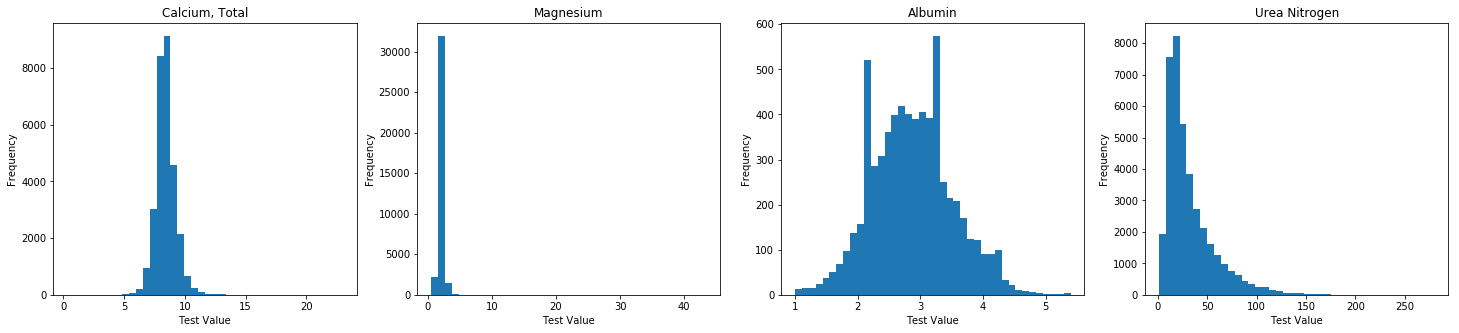

In [16]:
testNames = ['Calcium, Total', 'Magnesium', 'Albumin', 'Urea Nitrogen']

fig, axs = plt.subplots(1,4, sharex=False, sharey=False, figsize=(25,5))

index = 0
for i in range(4):
    temp = mergedLab.loc[(mergedLab['LABEL'] == testNames[i])]
    axs[i].hist(temp['VALUENUM'], 40)
    axs[i].set_title(testNames[i])
    axs[i].set_xlabel('Test Value')
    axs[i].set_ylabel('Frequency')

From the histogram visualizations, there does not appear to be a huge problem with the outliers, so processing to eliminate these outliers from the dataset was determined to be unnecessary.

## Machine Learning Data Prep

To be able to begin building our model, I then want to see which patients actually have experienced a 30-day admission. This will allow me to divide the training data into the *feature* variables and the *target* variables.

The *feature* variables will be all the variables that will be used as the inputs, predictors and attributes that will be used to predict the eventual outcome.

Meanwhile, the *target* variables are the output variables that depend on the feature variables.

For this, I'll need three columns from the merged dataset, the Subject_ID, Admit time and Discharge Time, which I will separate from the rest of the data set to make the memory more manageable. 

In [18]:
subset = mergedAdmission[['SUBJECT_ID', 'ADMITTIME', 'DISCHTIME']]
subset.shape

(58976, 3)

In [19]:
subset.head()

,SUBJECT_ID,ADMITTIME,DISCHTIME
0,249,2149-12-17 20:41:00,2149-12-31 14:55:00
1,249,2155-02-03 20:16:00,2155-02-14 11:15:00
2,249,2156-04-27 15:33:00,2156-05-14 15:30:00
3,250,2188-11-12 09:22:00,2188-11-22 12:00:00
4,251,2110-07-27 06:46:00,2110-07-29 15:23:00


In [ ]:
subset['Readmission_Time'] = 0

#for i in range(58976):
#    subset['Readmission_Time'][i] = (subset['DISCHTIME'][i] - subset['ADMITTIME'][i]).days
    
#subset.head()
    